# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import random

# Auction process 

In [2]:
# def auction_process(available_agv):
#     agv_bid_list = []
#     for agv in available_agv:
#         agv_bid_list.append(calculate_cost(agv,jobQ,warehouse,INPUT_STATION,OUTPUT_STATION))
#     min_agv_cost = min(agv_bid_list)
#     target_agv = available_agv[agv_bid_list.index(min_agv_cost)]
#     return target_agv

In [3]:
def Auction_process(available_agv,jobQ):
    agv_bid_list = []
    for agv in available_agv:
        if calculate_cost(agv,jobQ,warehouse,INPUT_STATION,OUTPUT_STATION) != None:
            agv_bid_list.append(calculate_cost(agv,jobQ,warehouse,INPUT_STATION,OUTPUT_STATION))
    min_agv_cost = min(agv_bid_list)
    target_agv = available_agv[agv_bid_list.index(min_agv_cost)]
    return target_agv

# Create job

In [49]:
job_time_interval = np.random.poisson(100,1000)
job_create_time = [sum(job_time_interval[:i]) for i in range(len(job_time_interval)+1)]
print(job_time_interval)
print(job_create_time)
print(len(job_create_time))

[101  87 105 ...  83  94  95]
[0, 101, 188, 293, 386, 495, 598, 681, 774, 870, 950, 1081, 1189, 1291, 1405, 1495, 1613, 1709, 1803, 1915, 2023, 2111, 2229, 2310, 2413, 2522, 2620, 2729, 2827, 2937, 3046, 3170, 3282, 3370, 3465, 3570, 3670, 3766, 3854, 3943, 4035, 4133, 4229, 4331, 4406, 4509, 4614, 4696, 4810, 4909, 5004, 5083, 5190, 5301, 5402, 5494, 5601, 5705, 5796, 5902, 6011, 6111, 6204, 6308, 6415, 6509, 6633, 6754, 6845, 6946, 7040, 7138, 7219, 7329, 7429, 7546, 7634, 7718, 7823, 7942, 8048, 8152, 8244, 8336, 8436, 8536, 8645, 8737, 8832, 8936, 9037, 9124, 9221, 9319, 9408, 9521, 9626, 9725, 9827, 9924, 10033, 10119, 10218, 10327, 10422, 10526, 10629, 10732, 10829, 10934, 11034, 11132, 11245, 11364, 11464, 11570, 11660, 11754, 11852, 11943, 12053, 12174, 12278, 12396, 12487, 12590, 12685, 12763, 12871, 12983, 13074, 13173, 13270, 13398, 13493, 13589, 13689, 13782, 13877, 13959, 14056, 14156, 14247, 14332, 14441, 14527, 14624, 14720, 14816, 14921, 15025, 15125, 15228, 15339, 1543

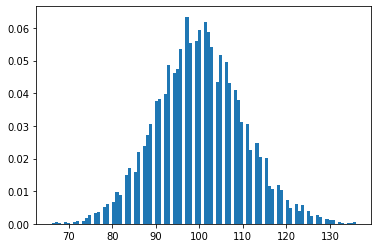

In [50]:
count, bins, ignored = plt.hist(job_time_interval, 100, density = True)
plt.show()

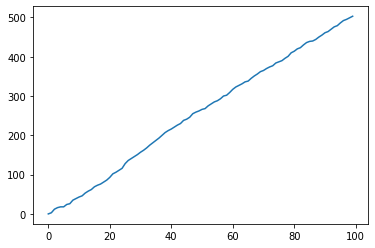

In [6]:
plt.plot(job_create_time)
plt.show()

In [7]:
class JobQueue(object):
    
    def __init__(self):
        self.job_q = queue.Queue()
        self.job_number = 0
        
    def insertJob(self, inout,  station_dest):
        job = {"inout": inout, "station_dest": station_dest}
        self.job_q.put(job)
        self.job_number+=1

    def getJob(self):
        if self.job_q.empty():
            return 
        self.job_number-=1
        return self.job_q.get()

In [8]:
def job_create(rack_location,job_create_time,jobQ,total_job_location_list):
    job_location = [random.choice(rack_location)]
    if total_job_location_list.count(job_location)%2==0:
        jobQ.insertJob("in",job_location)
    else:
        jobQ.insertJob("out",job_location)
    total_job_location_list.append(job_location)
    return jobQ

# AGV

In [9]:
class AGV(object):
    max_battery = 1000
    charger = [(10,6)]
    
    
    def __init__(self,agv_id,current_location,current_tick=0):
        self.agv_id = agv_id
        self.battery = self.max_battery
        self.current_location = current_location
        self.job = None
        self.destination = None
        self.available = True
        self.current_tick = current_tick

    
    def move_one_tick(self):
        self.next_location = self.path[0]
        self.current_location = self.next_location
        del self.astar_path[0]
        self.battery -=1
        self.current_tick +=1
    
    def get_job(self,job,astar_path):
        self.job = job
        self.path = astar_path
        self.available = False
        
        

In [10]:
def getAvailAGV(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery > battery_threshold]

# Astar

In [11]:
class node:
    def __init__(self,parent=None, position = None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self,other):
        return self.position == other.position

In [12]:
def manhattan_distance(start_node,goal_node):
    dx = abs(start_node[0]-goal_node[0])
    dy = abs(start_node[1]-goal_node[1])
    return dx + dy

In [41]:
def astar(graph,start,goal):
    start_node = node(None,(start[1],start[0]))
    goal_node = node(None,(goal[1],goal[0]))
    open_list = []
    closed_list = []
    graph = [el for el in graph][::-1]
#     for i in graph:
#         print(i)
    
    open_list.append(start_node)
    while open_list:
        current_node = open_list[0]
        current_index = 0
        
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        if current_node == goal_node:
            path = []
            current = current_node
            while current is not None:
                x,y = current.position
                graph[x][y] = 9
                path.append((current.position[1],current.position[0]))
                current = current.parent
                
            return path[::-1]
        
        children = []
        for new_position in [(0,1),(1,0),(-1,0),(0,-1)]:
            node_position = (current_node.position[0]+new_position[0],
                             current_node.position[1]+new_position[1])
            within_range = [
                node_position[1]>len(graph)-1,
                node_position[1]<0,
                node_position[0]>len(graph[len(graph)-1])-1,
                node_position[0]<0]
            if any(within_range):
                continue
            if graph[node_position[0]][node_position[1]] !=0:
                continue
            
            new_node = node(current_node, node_position)
            children.append(new_node)
        
        for child in children:
            if child in closed_list:
                continue
            child.g = current_node.g+1
            child.h = manhattan_distance(child.position,goal_node.position)
            child.f = child.g + child.h
            
            if len([open_node for open_node in open_list
                   if child == open_node and child.g>open_node.g]) > 0:
                continue
            open_list.append(child)
            

# Cost function

In [14]:
def calculate_cost(agv,jobQ,warehouse,INPUT_STATION,OUTPUT_STATION):
    if jobQ.job_number!=0:
        bidjob = jobQ.getJob()
        if bidjob['inout'] == 'in':
            cost = len(astar(warehouse,agv.current_location,INPUT_STATION))
        else:
            cost = len(astar(warehouse,agv.current_location,Rack_enterence[bidjob['station_dest']]))
        return cost

# Warehouse, Rack 

In [15]:
def make_warehouse(row,col):
    warehouse = [[0]*col for i in range(row)]
    return warehouse 

In [16]:
def set_rack(warehouse,rack_location):
    for idx, row in enumerate(warehouse):
        warehouse[idx] =  [1 if (ix, ROW -1 - idx) in rack_location else 0 for ix,col in enumerate(warehouse[idx])]

In [17]:
def get4Ways(point):
    return [(point[0],point[1]+1), (point[0]+1,point[1]),
            (point[0],point[1]-1), (point[0]-1,point[1])]

## Make  Warehouse, Rack, Rack enterence, Station

In [18]:
ROW, COL = 10,10
battery_threshold = 200
warehouse = make_warehouse(ROW,COL)

In [19]:
rack_location =  [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
                  (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), 
                  (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), 
                  (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), 
                  (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 
                  (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]

set_rack(warehouse,rack_location)

In [20]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

In [21]:
INPUT_STATION = (3,0)
OUTPUT_STATION = (6,0)
CHARGING_STATION = [(2,9),(6,9)]
agv1 = AGV("agv1",(0,9))
agv2 = AGV("agv2",(3,9))
agv3 = AGV("agv3",(6,9))
agv4 = AGV("agv4",(9,9))

In [22]:
warehouse

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

# Make Job queue, Job, AGV

In [23]:
jobQ = JobQueue()
total_job_location_list = []

In [24]:
agv1 = AGV("agv1",(0,9))
agv2 = AGV("agv2",(3,9))
agv3 = AGV("agv3",(6,9))
agv4 = AGV("agv4",(9,9))
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

In [42]:
warehouse

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [43]:
astar(warehouse,agv1.current_location,OUTPUT_STATION)

[(0, 9),
 (1, 9),
 (2, 9),
 (3, 9),
 (4, 9),
 (5, 9),
 (6, 9),
 (6, 8),
 (6, 7),
 (6, 6),
 (6, 5),
 (6, 4),
 (6, 3),
 (6, 2),
 (6, 1),
 (6, 0)]

In [44]:
warehouse

[[9, 9, 9, 9, 9, 9, 9, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 9, 0, 0, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 9, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 9, 0, 0, 0]]

In [26]:
job_create(rack_location,job_create_time,jobQ,total_job_location_list)
jobQ.job_number

1

In [27]:
jobQ.insertJob("in",(1,1))
jobQ.insertJob("out",(1,2))
jobQ.insertJob("in",(1,1))
jobQ.insertJob("out",(1,3))

In [28]:
for agv in getAvailAGV(AGV_LIST,battery_threshold):
    print(calculate_cost(agv,jobQ,warehouse,INPUT_STATION,OUTPUT_STATION))

13
10
14
16


In [29]:
Auction_process(getAvailAGV(AGV_LIST,battery_threshold),jobQ)

In [30]:
jobQ.getJob()['inout'] =='in'

TypeError: 'NoneType' object is not subscriptable

In [ ]:
jobQ.getJob()

In [ ]:
jobQ.getJob()

In [ ]:
jobQ.getJob()

# 실험

In [ ]:
getAvailAGV(AGV_LIST,battery_threshold)

In [ ]:
astar(warehouse,(0,0),(3,5))

In [ ]:
warehouse

# Main 함수

In [ ]:
print(job_create_time)
print(len(job_create_time))

In [ ]:
job_Q = JobQueue()
total_job_location_list = []
run_time =1
global_time_tick = 0

In [ ]:
#### 돌리려면 초기화해야됨
# for tick in range(run_time+1):
#     if tick in job_create_time:
#         job_create(rack_location,job_create_time,job_Q,total_job_location_list)
#     agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
# print(job_Q.job_number)
# print(agv_avail)   
# print(len(total_job_location_list))
# print(total_job_location_list)

In [ ]:
for tick in range(run_time):
    if tick in job_create_time:
        job_create(rack_location,job_create_time,job_Q,total_job_location_list)  
    agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
    if len(agv_avail) !=0 and job_Q.job_number!=0:
        target_agv = Auction_process(agv_avail,job_Q)
        print(target_agv)